In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# Import from other modules
from data_loader import get_cifar100_loaders
from evaluation_utils import (evaluate_model, plot_confusion_matrix,
                              visualize_misclassified, get_cifar100_class_names)

In [4]:
def train_model(model, train_loader, test_loader, num_epochs, learning_rate, device, model_name="convnext_tiny"):
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.05)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    model.to(device)
    best_accuracy = 0.0
    model_save_path = f'{model_name}_cifar100_best.pth'

    train_acc_history = []
    test_acc_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for i, (inputs, labels) in enumerate(train_iterator):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            train_iterator.set_postfix(loss=loss.item())

        epoch_loss_train = running_loss / len(train_loader.dataset)
        epoch_acc_train = 100.0 * correct_train / total_train
        train_acc_history.append(epoch_acc_train)

        # Validation
        model.eval()
        running_val_loss = 0.0
        correct_test = 0
        total_test = 0
        test_iterator = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for inputs, labels in test_iterator:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss_batch = criterion(outputs, labels)
                running_val_loss += val_loss_batch.item() * inputs.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(test_loader.dataset)
        val_loss_history.append(epoch_val_loss)
        epoch_acc_test = 100.0 * correct_test / total_test
        test_acc_history.append(epoch_acc_test)
        end_time = time.time()
        epoch_duration = end_time - start_time

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_loss_train:.4f} | Train Acc: {epoch_acc_train:.2f}% | '
              f'Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_acc_test:.2f}% | '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f} | '
              f'Duration: {epoch_duration:.2f}s')

        scheduler.step()

        if epoch_acc_test > best_accuracy:
            best_accuracy = epoch_acc_test
            try:
                torch.save(model.state_dict(), model_save_path)
                print(f'>>> Best model saved to {model_save_path} with Val Accuracy: {best_accuracy:.2f}%')
            except Exception as e:
                 print(f"Lỗi khi lưu model: {e}")

    print('Finished Training')
    print(f'Best Validation Accuracy achieved during training: {best_accuracy:.2f}%')

    print(f"Loading best model state from {model_save_path} for final evaluation...")
    try:
        model.load_state_dict(torch.load(model_save_path))
    except Exception as e:
        print(f"Could not load best model state: {e}. Evaluating with the final model state.")

    return model, train_acc_history, test_acc_history

Sử dụng thiết bị: cuda
Đang tải dữ liệu CIFAR-100 (resize: 224x224)...
Đã tải xong CIFAR-100.
Số lượng ảnh Train: 50000
Số lượng ảnh Test: 10000
Kích thước ảnh: 224x224
Sử dụng Data Augmentation: True
Khởi tạo 6_CONVNEXTTINY pre-trained model...
Đã thay thế lớp Linear trong classifier của ConvNeXt_Tiny bằng lớp Linear(768, 100)
Bắt đầu fine-tuning 6_CONVNEXTTINY...


Epoch 1/20 [Val]: 100%|██████████| 313/313 [00:24<00:00, 12.93it/s]


Epoch 1/20 | Train Loss: 4.5990 | Train Acc: 1.06% | Val Loss: 4.4715 | Val Acc: 1.99% | LR: 0.001000 | Duration: 1189.02s
>>> Best model saved to 6_ConvnextTiny_cifar100_best.pth with Val Accuracy: 1.99%


Epoch 2/20 [Val]: 100%|██████████| 313/313 [00:24<00:00, 12.64it/s]


Epoch 2/20 | Train Loss: 4.4760 | Train Acc: 2.36% | Val Loss: 4.2467 | Val Acc: 5.30% | LR: 0.000994 | Duration: 1187.74s
>>> Best model saved to 6_ConvnextTiny_cifar100_best.pth with Val Accuracy: 5.30%


Epoch 3/20 [Val]: 100%|██████████| 313/313 [00:24<00:00, 12.90it/s]


Epoch 3/20 | Train Loss: 4.2963 | Train Acc: 4.70% | Val Loss: 3.8985 | Val Acc: 9.70% | LR: 0.000976 | Duration: 1185.85s
>>> Best model saved to 6_ConvnextTiny_cifar100_best.pth with Val Accuracy: 9.70%


Epoch 4/20 [Val]: 100%|██████████| 313/313 [00:24<00:00, 12.81it/s]


Epoch 4/20 | Train Loss: 4.0364 | Train Acc: 8.36% | Val Loss: 3.4628 | Val Acc: 17.20% | LR: 0.000946 | Duration: 1189.82s
>>> Best model saved to 6_ConvnextTiny_cifar100_best.pth with Val Accuracy: 17.20%


Epoch 5/20 [Val]: 100%|██████████| 313/313 [00:24<00:00, 12.91it/s]


Epoch 5/20 | Train Loss: 3.6867 | Train Acc: 13.84% | Val Loss: 2.9497 | Val Acc: 25.85% | LR: 0.000905 | Duration: 1188.89s
>>> Best model saved to 6_ConvnextTiny_cifar100_best.pth with Val Accuracy: 25.85%


Epoch 6/20 [Val]: 100%|██████████| 313/313 [00:24<00:00, 12.88it/s]


Epoch 6/20 | Train Loss: 3.3248 | Train Acc: 20.29% | Val Loss: 2.5796 | Val Acc: 32.38% | LR: 0.000854 | Duration: 1186.07s
>>> Best model saved to 6_ConvnextTiny_cifar100_best.pth with Val Accuracy: 32.38%


Epoch 7/20 [Val]: 100%|██████████| 313/313 [00:24<00:00, 12.86it/s]


Epoch 7/20 | Train Loss: 3.0644 | Train Acc: 24.73% | Val Loss: 2.2926 | Val Acc: 39.83% | LR: 0.000794 | Duration: 1188.78s
>>> Best model saved to 6_ConvnextTiny_cifar100_best.pth with Val Accuracy: 39.83%


Epoch 8/20 [Val]: 100%|██████████| 313/313 [00:24<00:00, 12.95it/s]


Epoch 8/20 | Train Loss: 2.8317 | Train Acc: 29.30% | Val Loss: 2.0610 | Val Acc: 44.29% | LR: 0.000727 | Duration: 1188.90s
>>> Best model saved to 6_ConvnextTiny_cifar100_best.pth with Val Accuracy: 44.29%


Epoch 9/20 [Val]: 100%|██████████| 313/313 [00:24<00:00, 12.68it/s]


Epoch 9/20 | Train Loss: 2.6288 | Train Acc: 33.47% | Val Loss: 1.9047 | Val Acc: 47.97% | LR: 0.000655 | Duration: 1186.17s
>>> Best model saved to 6_ConvnextTiny_cifar100_best.pth with Val Accuracy: 47.97%


Epoch 10/20 [Val]: 100%|██████████| 313/313 [00:24<00:00, 12.94it/s]


Epoch 10/20 | Train Loss: 2.4594 | Train Acc: 37.13% | Val Loss: 1.7826 | Val Acc: 50.67% | LR: 0.000579 | Duration: 1186.26s
>>> Best model saved to 6_ConvnextTiny_cifar100_best.pth with Val Accuracy: 50.67%


Epoch 11/20 [Val]: 100%|██████████| 313/313 [00:24<00:00, 12.92it/s]


Epoch 11/20 | Train Loss: 2.3098 | Train Acc: 40.26% | Val Loss: 1.6710 | Val Acc: 53.88% | LR: 0.000501 | Duration: 1186.74s
>>> Best model saved to 6_ConvnextTiny_cifar100_best.pth with Val Accuracy: 53.88%


Epoch 12/20 [Val]: 100%|██████████| 313/313 [00:24<00:00, 12.97it/s]


Epoch 12/20 | Train Loss: 2.1665 | Train Acc: 43.29% | Val Loss: 1.5291 | Val Acc: 57.27% | LR: 0.000422 | Duration: 1188.07s
>>> Best model saved to 6_ConvnextTiny_cifar100_best.pth with Val Accuracy: 57.27%


Epoch 13/20 [Val]: 100%|██████████| 313/313 [00:24<00:00, 12.89it/s]


Epoch 13/20 | Train Loss: 2.0279 | Train Acc: 46.44% | Val Loss: 1.4535 | Val Acc: 58.82% | LR: 0.000346 | Duration: 1189.70s
>>> Best model saved to 6_ConvnextTiny_cifar100_best.pth with Val Accuracy: 58.82%


Epoch 14/20 [Val]: 100%|██████████| 313/313 [00:24<00:00, 12.72it/s]


Epoch 14/20 | Train Loss: 1.9089 | Train Acc: 49.28% | Val Loss: 1.3854 | Val Acc: 61.16% | LR: 0.000274 | Duration: 1191.67s
>>> Best model saved to 6_ConvnextTiny_cifar100_best.pth with Val Accuracy: 61.16%


Epoch 15/20 [Val]: 100%|██████████| 313/313 [00:24<00:00, 12.97it/s]


Epoch 15/20 | Train Loss: 1.7942 | Train Acc: 51.85% | Val Loss: 1.3050 | Val Acc: 63.04% | LR: 0.000207 | Duration: 1187.07s
>>> Best model saved to 6_ConvnextTiny_cifar100_best.pth with Val Accuracy: 63.04%


Epoch 16/20 [Val]: 100%|██████████| 313/313 [00:24<00:00, 12.72it/s]


Epoch 16/20 | Train Loss: 1.7075 | Train Acc: 54.02% | Val Loss: 1.2666 | Val Acc: 63.96% | LR: 0.000147 | Duration: 1185.35s
>>> Best model saved to 6_ConvnextTiny_cifar100_best.pth with Val Accuracy: 63.96%


Epoch 17/20 [Val]: 100%|██████████| 313/313 [00:24<00:00, 12.87it/s]


Epoch 17/20 | Train Loss: 1.6202 | Train Acc: 55.97% | Val Loss: 1.2231 | Val Acc: 65.24% | LR: 0.000096 | Duration: 1186.71s
>>> Best model saved to 6_ConvnextTiny_cifar100_best.pth with Val Accuracy: 65.24%


Epoch 18/20 [Val]: 100%|██████████| 313/313 [00:24<00:00, 12.92it/s]


Epoch 18/20 | Train Loss: 1.5577 | Train Acc: 57.62% | Val Loss: 1.2016 | Val Acc: 66.08% | LR: 0.000055 | Duration: 1182.22s
>>> Best model saved to 6_ConvnextTiny_cifar100_best.pth with Val Accuracy: 66.08%


Epoch 19/20 [Val]: 100%|██████████| 313/313 [00:24<00:00, 12.86it/s]


Epoch 19/20 | Train Loss: 1.5041 | Train Acc: 59.06% | Val Loss: 1.1884 | Val Acc: 66.19% | LR: 0.000025 | Duration: 1182.89s
>>> Best model saved to 6_ConvnextTiny_cifar100_best.pth with Val Accuracy: 66.19%


Epoch 20/20 [Val]: 100%|██████████| 313/313 [00:24<00:00, 12.71it/s]


Epoch 20/20 | Train Loss: 1.4790 | Train Acc: 59.52% | Val Loss: 1.1857 | Val Acc: 66.33% | LR: 0.000007 | Duration: 1185.11s
>>> Best model saved to 6_ConvnextTiny_cifar100_best.pth with Val Accuracy: 66.33%
Finished Training
Best Validation Accuracy achieved during training: 66.33%
Loading best model state from 6_ConvnextTiny_cifar100_best.pth for final evaluation...

--- Performing Final Evaluation on Test Set for 6_CONVNEXTTINY ---
Evaluating on test set...


  0%|          | 0/313 [00:00<?, ?it/s]


Classification Report:
               precision    recall  f1-score   support

        apple       0.81      0.84      0.82       100
aquarium_fish       0.78      0.76      0.77       100
         baby       0.47      0.58      0.52       100
         bear       0.51      0.34      0.41       100
       beaver       0.42      0.45      0.43       100
          bed       0.70      0.73      0.72       100
          bee       0.72      0.74      0.73       100
       beetle       0.70      0.69      0.70       100
      bicycle       0.87      0.84      0.85       100
       bottle       0.74      0.77      0.75       100
         bowl       0.54      0.49      0.52       100
          boy       0.45      0.35      0.40       100
       bridge       0.84      0.77      0.80       100
          bus       0.66      0.54      0.59       100
    butterfly       0.65      0.62      0.63       100
        camel       0.63      0.70      0.66       100
          can       0.66      0.63      

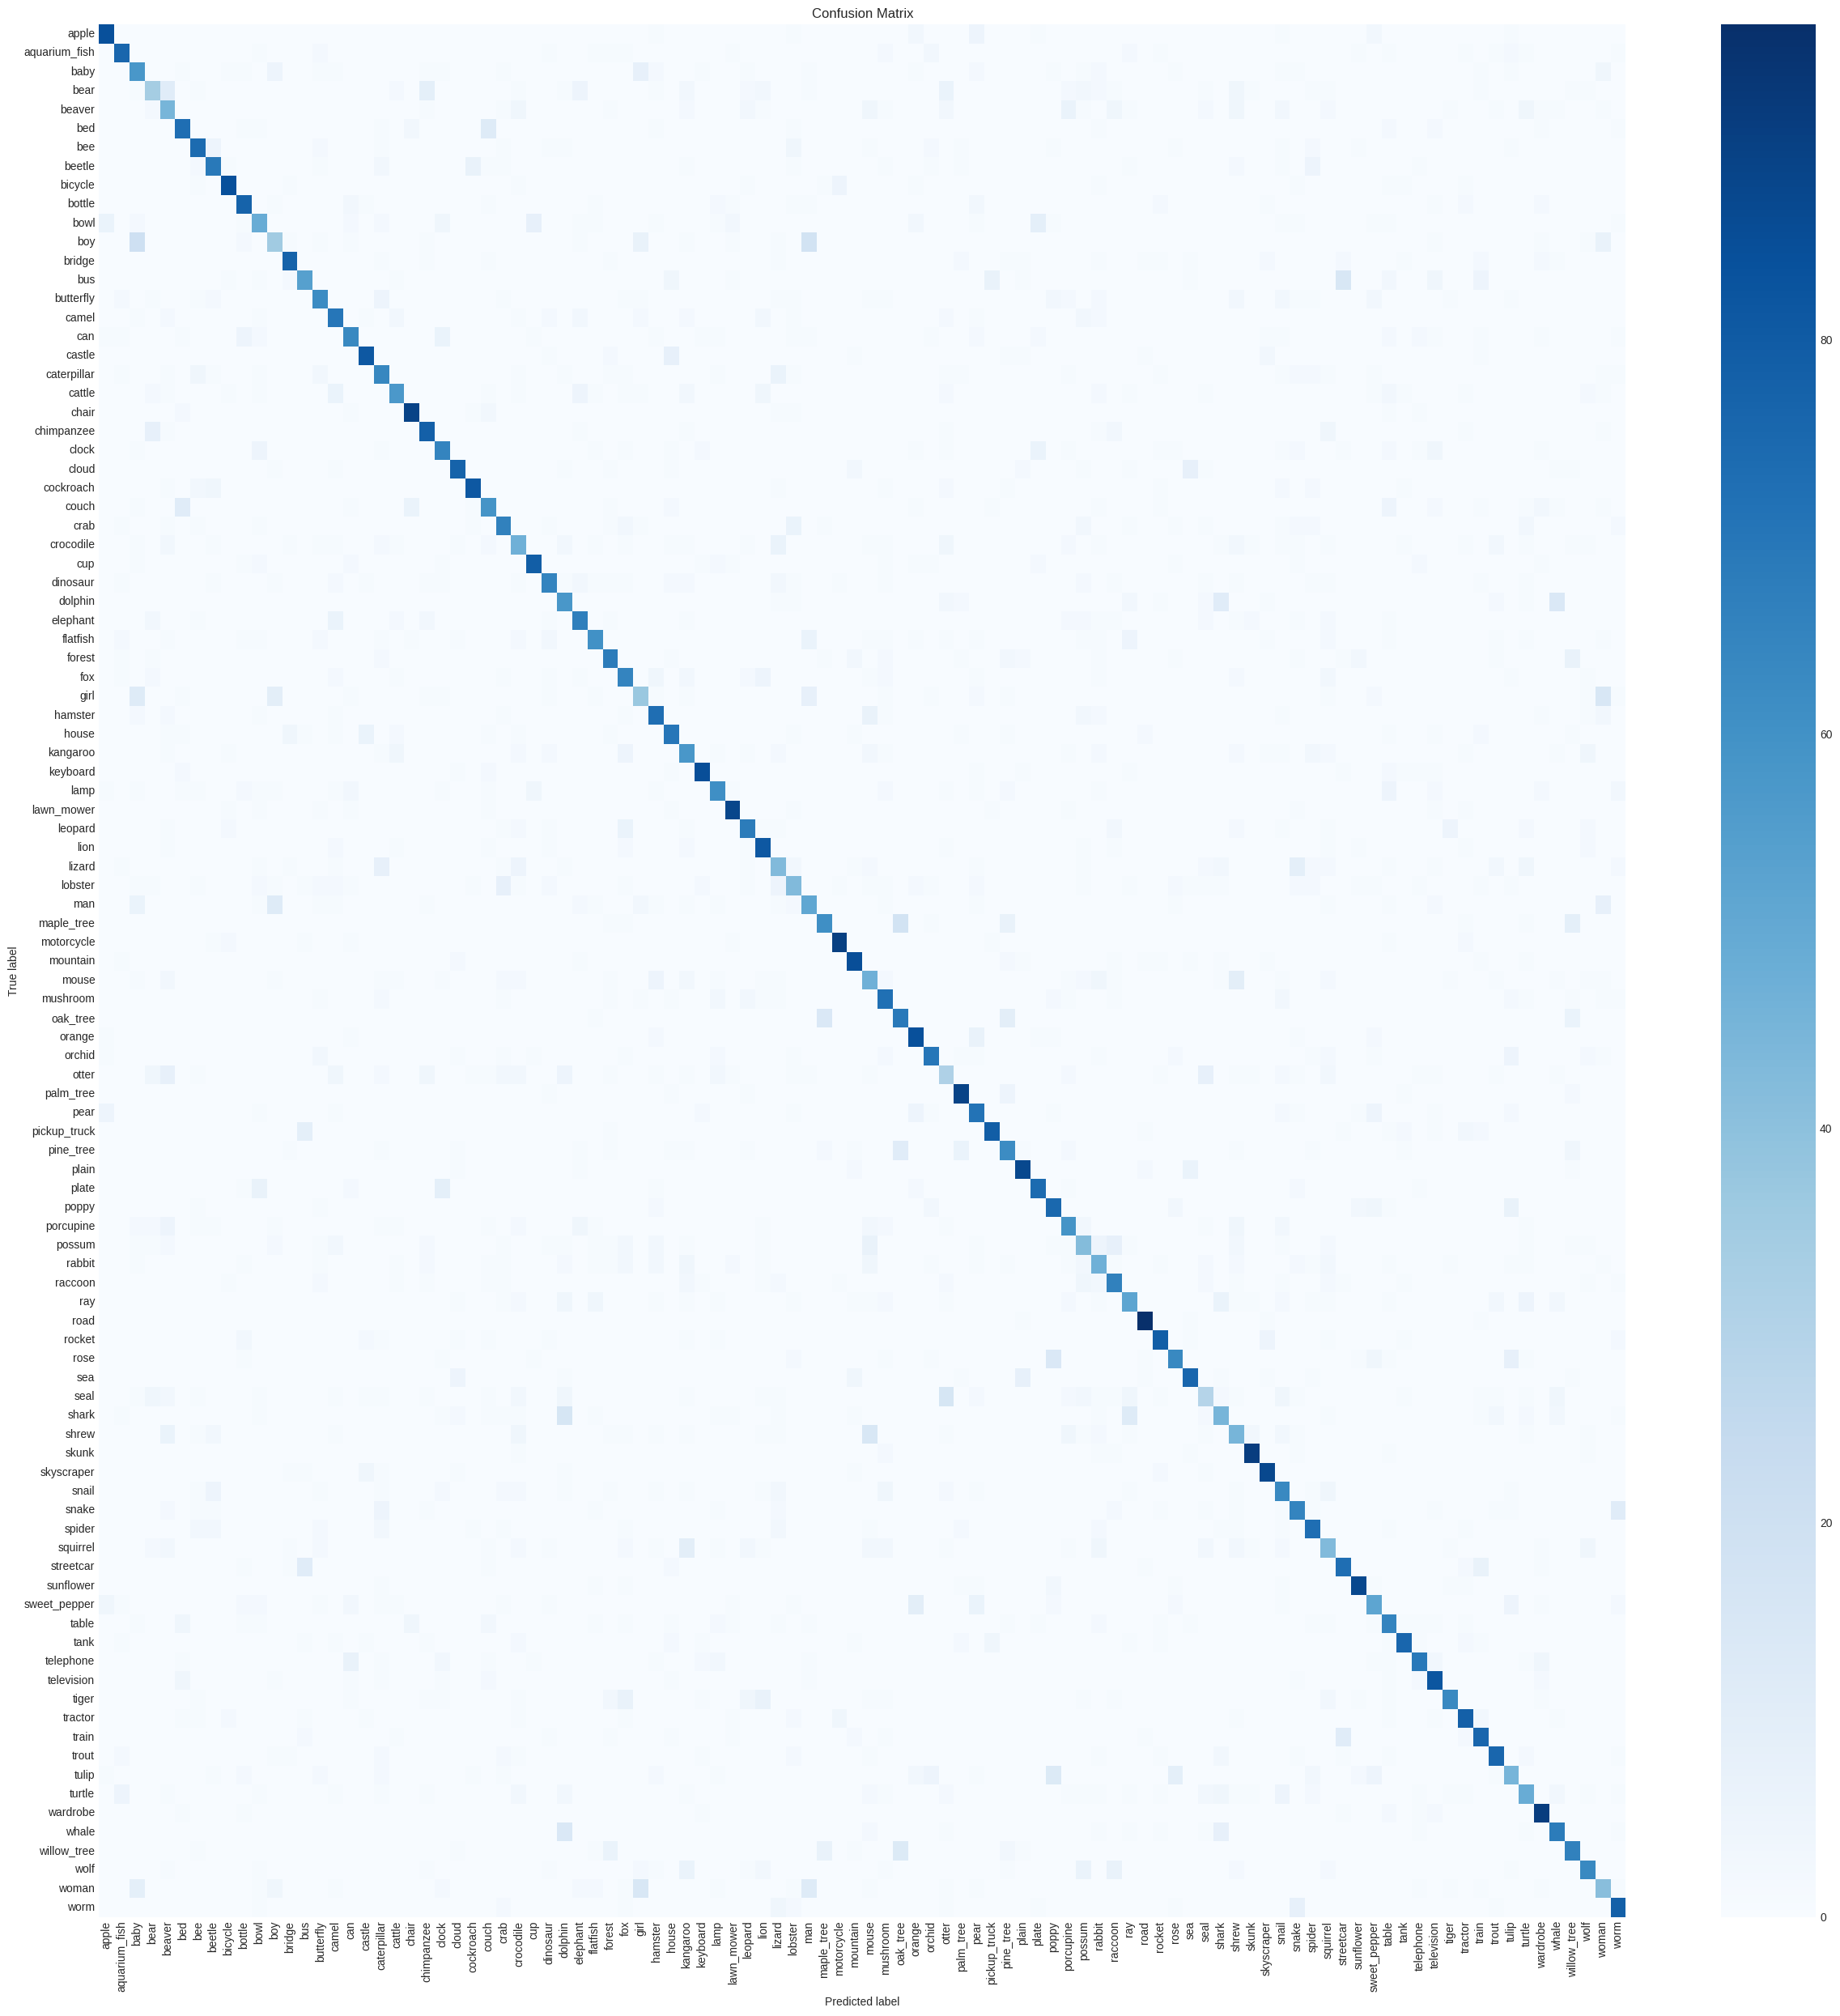


Searching for 25 misclassified images...


  0%|          | 0/313 [00:00<?, ?it/s]

Visualizing 25 misclassified images...
Misclassified images visualization saved to 6_ConvnextTiny_misclassified_25.png


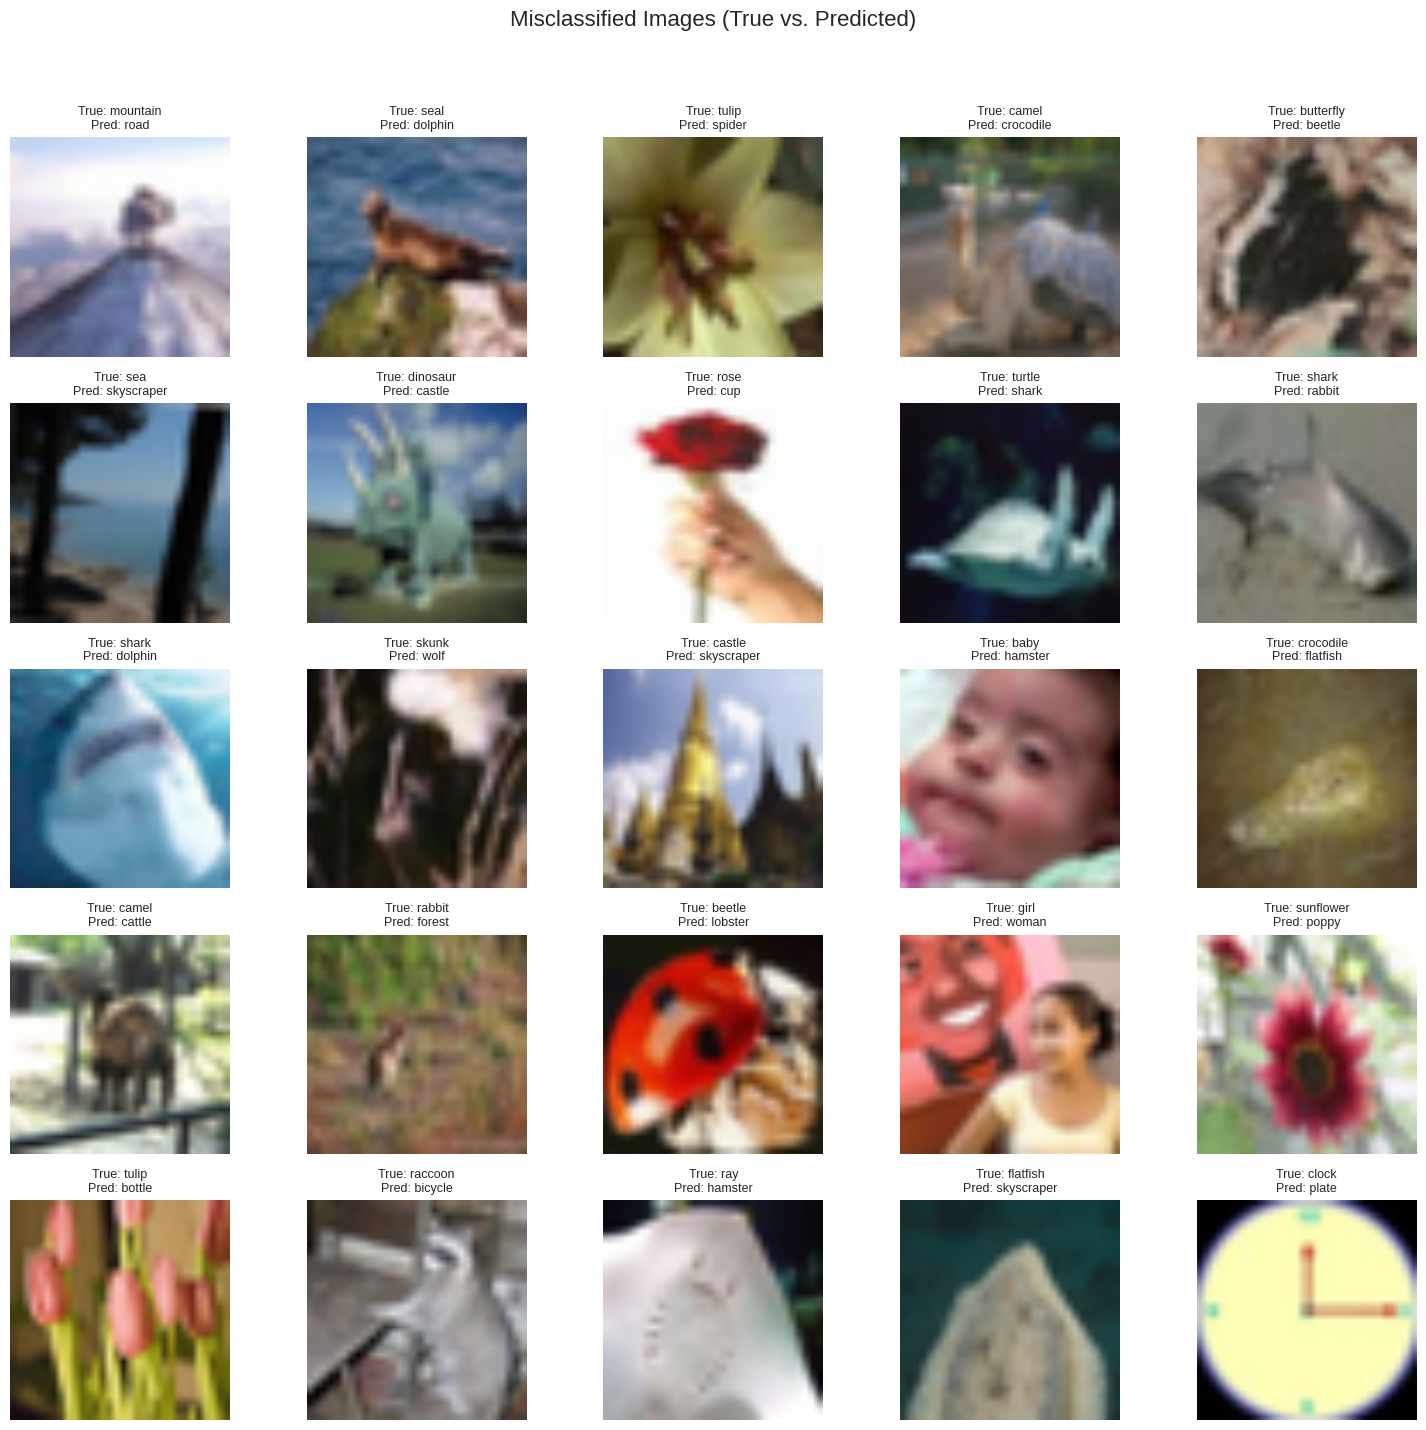

Accuracy history plot saved to 6_ConvnextTiny_accuracy_history.png


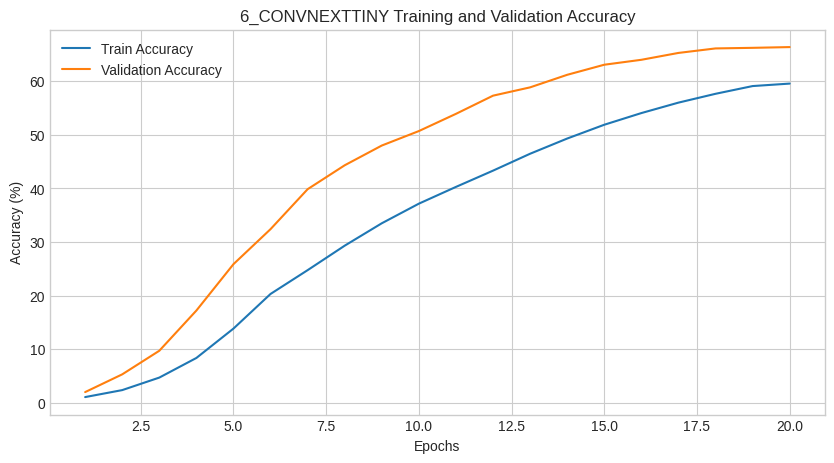

In [5]:
NUM_EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.001    # ConvNeXt fine-tuning often uses smaller learning rates
IMG_SIZE = 224
USE_AUGMENTATION = True
DATA_DIR = './data_cifar100'
NUM_WORKERS = 4
MODEL_NAME = "6_ConvnextTiny"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

class_names = get_cifar100_class_names(DATA_DIR)
num_classes = len(class_names)

print(f"Đang tải dữ liệu CIFAR-100 (resize: {IMG_SIZE}x{IMG_SIZE})...")
train_loader, test_loader, _ = get_cifar100_loaders(
    batch_size=BATCH_SIZE,
    data_dir=DATA_DIR,
    img_size=IMG_SIZE,
    use_augmentation=USE_AUGMENTATION,
    num_workers=NUM_WORKERS
)

if train_loader is None:
    print("Không thể tải dữ liệu. Kết thúc chương trình.")
    exit()

print(f"Khởi tạo {MODEL_NAME.upper()} pre-trained model...")
weights = models.ConvNeXt_Tiny_Weights.DEFAULT
model = models.convnext_tiny(weights=weights)

# --- Modify the classifier for CIFAR-100 ---
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_ftrs, num_classes)
print(f"Đã thay thế lớp Linear trong classifier của ConvNeXt_Tiny bằng lớp Linear({num_ftrs}, {num_classes})")

print(f"Bắt đầu fine-tuning {MODEL_NAME.upper()}...")
trained_model, train_history, test_history = train_model(
    model, train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, device, model_name=MODEL_NAME
)

# --- Final Evaluation and Visualization ---
print(f"\n--- Performing Final Evaluation on Test Set for {MODEL_NAME.upper()} ---")
final_metrics = evaluate_model(trained_model, test_loader, device, num_classes, class_names)

if 'confusion_matrix' in final_metrics:
    plot_confusion_matrix(final_metrics['confusion_matrix'], class_names,
                            filename=f'{MODEL_NAME}_confusion_matrix.png',
                            figsize=(25, 25))

visualize_misclassified(trained_model, test_loader, device, class_names,
                        num_images=25,
                        filename_prefix=f'{MODEL_NAME}_misclassified')

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_history, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), test_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title(f'{MODEL_NAME.upper()} Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(f'{MODEL_NAME}_accuracy_history.png')
print(f"Accuracy history plot saved to {MODEL_NAME}_accuracy_history.png")
plt.show()